In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

In [2]:
parc_id_table_path = 'gene/parcellation_to_parcellation_term_membership_acronym.csv'
parc_id_table = pd.read_csv(parc_id_table_path)

In [3]:
parc_id_match = {}
id_parc_match = {}
for i in range(len(parc_id_table)):
    parc_id_match[parc_id_table['parcellation_index'].iloc[i]] = parc_id_table['substructure'].iloc[i]
    id_parc_match[parc_id_table['substructure'].iloc[i]] = parc_id_table['parcellation_index'].iloc[i]

In [5]:
T1 = pd.read_csv('gene/screened1_matrix.csv')

In [66]:
T2 = pd.read_csv('gene/screened2_matrix.csv')
T3 = pd.read_csv('gene/screened3_matrix.csv')
T4 = pd.read_csv('gene/screened4_matrix.csv')

In [417]:
T1[['cell_label', 'x', 'y', 'z','parcellation_index']].to_csv('gene/screened_info1.csv',index=None)

In [418]:
T2[['cell_label', 'x', 'y', 'z','parcellation_index']].to_csv('gene/screened_info2.csv',index=None)
T3[['cell_label', 'x', 'y', 'z','parcellation_index']].to_csv('gene/screened_info3.csv',index=None)
T4[['cell_label', 'x', 'y', 'z','parcellation_index']].to_csv('gene/screened_info4.csv',index=None)

In [6]:
### brain region classification
T1_R = np.array(T1['parcellation_index'].apply(lambda x: parc_id_match[x]))

In [67]:
T2_R = np.array(T2['parcellation_index'].apply(lambda x: parc_id_match[x]))
T3_R = np.array(T3['parcellation_index'].apply(lambda x: parc_id_match[x]))
T4_R = np.array(T4['parcellation_index'].apply(lambda x: parc_id_match[x]))

In [7]:
parc_id_match_reverse = {}
for k,v in parc_id_match.items():
    parc_id_match_reverse[v] = k

In [12]:
import glob
import os
import sys
sys.path.append("../pylib-main")
from file_io import load_image

In [18]:
parc_count = {}
final_parc_folder = 'lyf/output_full_r671'
for f in glob.glob(final_parc_folder+"/*"):
    f_name = os.path.basename(f)
    region_id = int(f_name.split(".")[0].split("parc_region")[1])
    image_tmp = load_image(f)
    n = np.max(image_tmp)
    parc_count[region_id] = n

In [13]:
from anatomy.anatomy_config import REGION671
import json

In [14]:
tree_json_path = 'tree_yzx.json'
with open(tree_json_path, 'r') as file:
    tree_json = json.load(file) 

In [15]:
brain_to_id = {}
id_to_brain = {}
brain_id_path = {}
for i in range(len(tree_json)):
    bid = tree_json[i]['id']
    acronym = tree_json[i]['acronym']
    p = tree_json[i]['structure_id_path']
    if bid not in brain_to_id:
        brain_to_id[bid] = acronym
        id_to_brain[acronym] = bid
    if bid not in brain_id_path:
        brain_id_path[bid] = p 

In [19]:
R_name_list = []
for k, v in parc_count.items():
    R_name = brain_to_id[k]
    R_name_list.append(R_name)

##### Gene Expression Matrix & ME Matrix

In [13]:
col_s = T1.columns[1:1123]

In [14]:
expression_df = []
selected_R = []
for n in R_name_list:
    if n in parc_id_match_reverse:
        nid = parc_id_match_reverse[n]
        rows1 = T1[T1['parcellation_index']==nid]
        # rows2 = T2[T2['parcellation_index']==nid]
        # rows3 = T3[T3['parcellation_index']==nid]
        # rows4 = T4[T4['parcellation_index']==nid]
        # tmp_df = pd.concat([rows1,rows2,rows3,rows4])
        if len(rows1) > 0:
            selected_R.append(n)
            expression_df.append(np.array(rows1[col_s].mean()))

In [15]:
me_df_path = 'BrainParcellation/microenviron/data/mefeatures_100K_with_PCAfeatures3.csv'
me_df = pd.read_csv(me_df_path,comment="#",index_col=0)

In [16]:
col_s1 = list(me_df.columns[:22])+list(me_df.columns[28:34])
col_s2 = me_df.columns[34:58]

In [17]:
major_BS = [688,549,623,313,1065,512,1097]
major_BS_name = ['CTX','TH','CNU','MB','HB','CB','HY','others']
region_Rough = {}
for i in REGION671:
    tmp_p = brain_id_path[i]
    flag = False
    for j in range(len(major_BS)):
        if major_BS[j] in tmp_p:
            region_Rough[brain_to_id[i]] = major_BS_name[j]
            flag = True
    if flag == False:
        region_Rough[brain_to_id[i]] = major_BS_name[len(major_BS_name)-1]

In [18]:
morpho_mean_df = []
me_mean_df = []
keep_indices = []
count_id = 0
for n in selected_R:
    rows = me_df[me_df['region_name_r671']==n]
    if len(rows) < 10:
        count_id += 1
        continue
    me_mean_df.append(np.array(rows[col_s2].mean()))
    morpho_mean_df.append(np.array(rows[col_s1].mean()))
    keep_indices.append(count_id)
    count_id += 1

In [19]:
region_selected = np.array(selected_R)[keep_indices]
region_R_selected = [region_Rough[x] for x in region_selected]

In [20]:
region_names = np.array(R_name_list)[keep_indices]
R_name_table = pd.DataFrame({'region_name':region_names})
R_name_table['rough'] = R_name_table['region_name'].apply(lambda x: region_Rough[x])

In [24]:
R_name_table.to_csv('gene/corr_Rnames.csv')

In [21]:
me_mean_df = np.array(me_mean_df)
me_mean_df.shape

(377, 24)

In [22]:
morpho_mean_df = np.array(morpho_mean_df)
morpho_mean_df.shape

(377, 28)

In [23]:
expression_df = np.array(expression_df)[keep_indices,:]
expression_df.shape

(377, 1122)

In [24]:
from scipy.spatial.distance import cdist
from sklearn import preprocessing

In [50]:
S_exp1 = (expression_df-np.mean(expression_df,axis=0))/np.std(expression_df,axis=0)
scaler = preprocessing.Normalizer(norm='l2')
S_exp2 = scaler.fit_transform(S_exp1)

D_exp = cdist(S_exp2,S_exp2,metric = 'cosine')
D_exp2 = (2-D_exp)/2

In [30]:
np.savetxt('gene/gene_corr.csv',D_exp,header='')

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [29]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mc
# h_rgblist = [[69,168,203],[147,203,225],[200,234,224],[253,230,236],[254,188,204],[243,131,160]]
# h_list = []
# for rgb in h_rgblist:
#     rgb = [i/255 for i in rgb]
#     h_list.append(mc.to_hex(rgb))
h_list = ['#1D3557','#457B9D','#FAF3EE','#F7A6A4','#E63946']
h_cmp = LinearSegmentedColormap.from_list("a",h_list)

/home/penglab/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/penglab/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


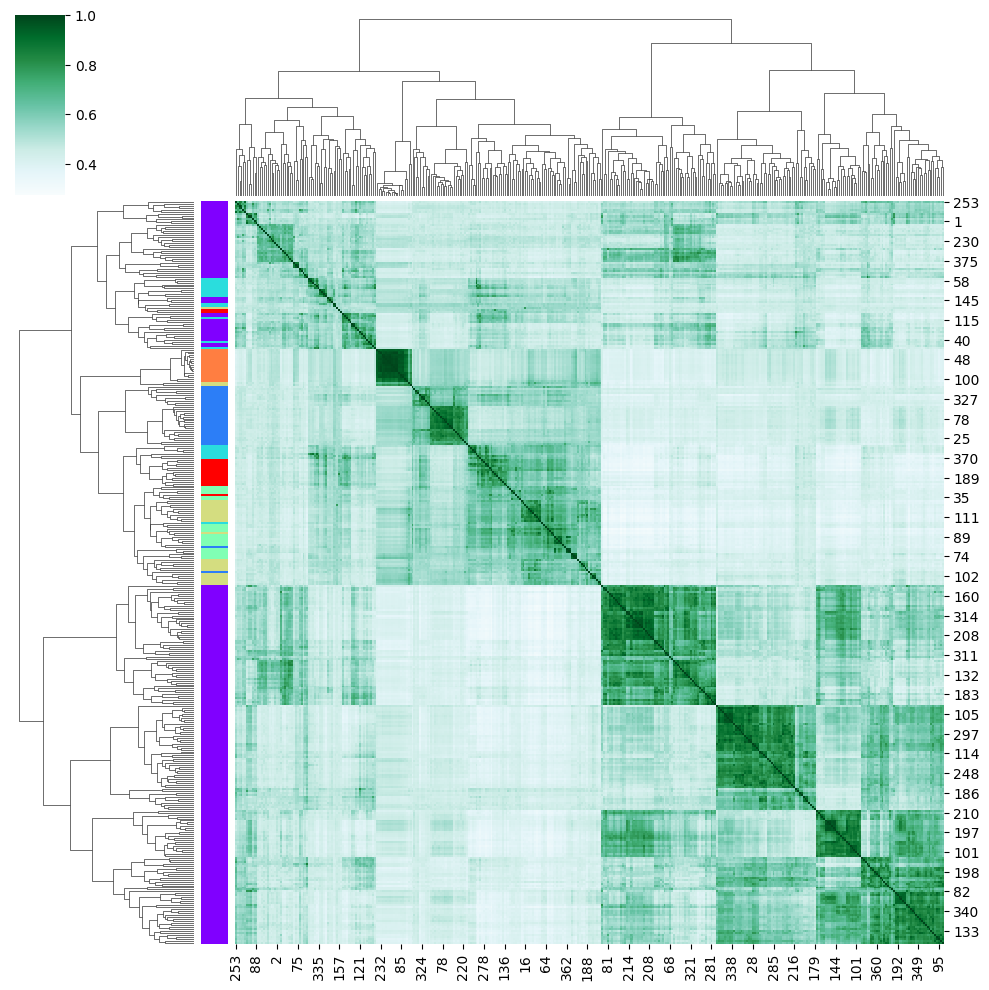

In [51]:
cmap = mpl.cm.rainbow
color_hm = cmap(np.linspace(0,1,len(major_BS_name)-1))
color_hm2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in color_hm]
c = dict(zip(major_BS_name[:-1],color_hm2))
row_c = list(map(lambda x:c[x], region_R_selected))
g_exp = sns.clustermap(data = D_exp2,
                       row_colors = row_c,
                       cmap='BuGn',
                       )
plt.savefig('all_figs/Fig5/gene_matrix.png',dpi=300)

In [31]:
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

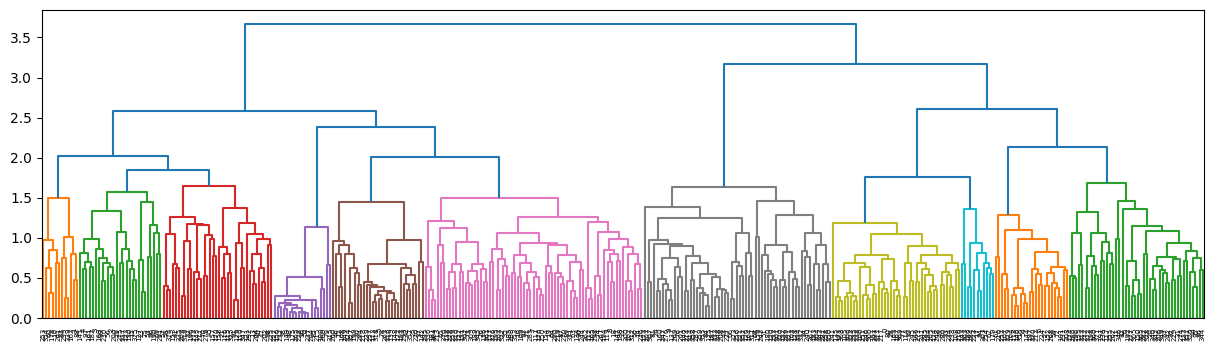

In [32]:
plt.figure(figsize=(15,4))
row_linkage = linkage(D_exp,method='average')
row_dendro = dendrogram(row_linkage,color_threshold=1.7)
plt.savefig('all_figs/Fig5/cluster_exp.png',dpi=300)

In [33]:
row_clusters = fcluster(row_linkage,t=1.7,criterion='distance')

In [52]:
S_me = (me_mean_df-np.mean(me_mean_df,axis=0))/np.std(me_mean_df,axis=0)
S_me1 = (me_mean_df-np.mean(me_mean_df,axis=0))/np.std(me_mean_df,axis=0)
scaler = preprocessing.Normalizer(norm='l2')
S_me2 = scaler.fit_transform(S_me1)

D_me = cdist(S_me2,S_me2,metric = 'cosine')
# D_me = 1/(1+np.log(1+D_me))
# D_me = 1/(1+D_me)
# D_me = np.exp(-0.5*D_me**0.5)
D_me2 = np.exp(-D_me)

In [35]:
np.savetxt('gene/me_corr.csv',D_me,header='')

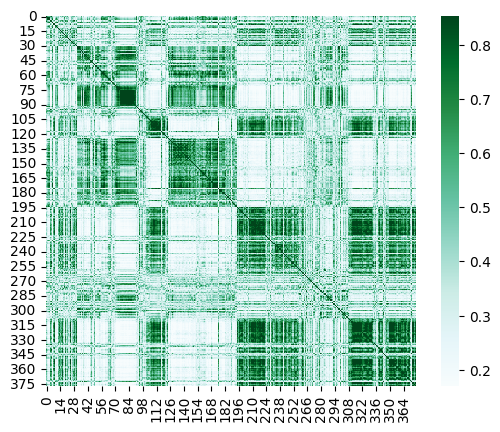

In [53]:
sns.heatmap(D_me2[g_exp.dendrogram_col.reordered_ind,:][:,g_exp.dendrogram_col.reordered_ind],
            square=True,cmap='BuGn',robust=True)
plt.savefig('all_figs/Fig5/memorpho_matrix.png',dpi=100)

In [54]:
S_morpho1 = (morpho_mean_df-np.mean(morpho_mean_df,axis=0))/np.std(morpho_mean_df,axis=0)
scaler = preprocessing.Normalizer(norm='l2')
S_morpho2 = scaler.fit_transform(S_morpho1)

D_morpho = cdist(S_morpho2,S_morpho2,metric = 'cosine')
D_morpho2 = np.exp(-D_morpho)

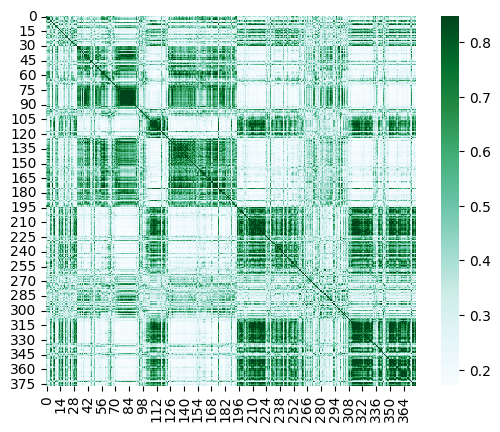

In [55]:
sns.heatmap(D_morpho2[g_exp.dendrogram_col.reordered_ind,:][:,g_exp.dendrogram_col.reordered_ind],
            square=True,cmap='BuGn',robust=True)
plt.savefig('all_figs/Fig5/morpho_matrix.png',dpi=100)

In [61]:
### heatmap similarity
from sklearn.metrics import mean_squared_error
cluster_ratio = []
### min-max standardization
D_exp3 = (D_exp-np.min(D_exp))/(np.max(D_exp)-np.min(D_exp))
D_me3 = (D_me-np.min(D_me))/(np.max(D_me)-np.min(D_me))
for i in np.unique(row_clusters):
    D1 = D_exp3[row_clusters==i,:][:,row_clusters==i]
    D2 = D_me3[row_clusters==i,:][:,row_clusters==i]
    intra_D1 = (D1.sum() - D1.trace())/2
    intra_D2 = (D2.sum() - D2.trace())/2
    be_D1 = (D_exp3.sum() - D_exp3.trace())/2 - intra_D1
    be_D2 = (D_me3.sum() - D_me3.trace())/2 - intra_D2
    r1 = be_D1/intra_D1
    r2 = be_D2/intra_D2
    cluster_ratio.append([r1,r2])

In [62]:
cluster_ratio = np.array(cluster_ratio)

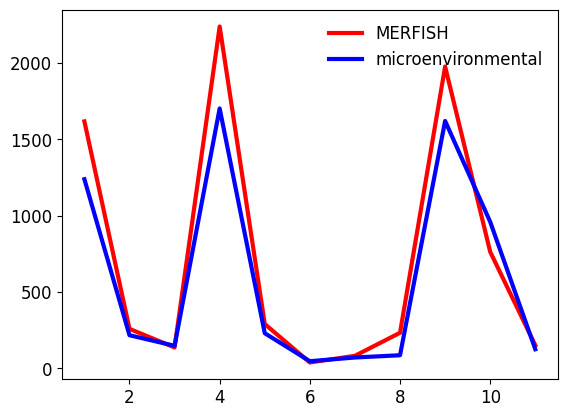

In [64]:
plt.plot(np.arange(1,np.max(row_clusters)+1,1),cluster_ratio[:,0],color = 'r',label='MERFISH',linewidth=3)
plt.plot(np.arange(1,np.max(row_clusters)+1,1),cluster_ratio[:,1],color = 'b',label='microenvironmental',linewidth=3)
plt.legend(frameon=False,fontsize=12,loc='upper right')
plt.tick_params(axis='both',labelsize=12)
plt.savefig('all_figs/Fig5/full_comparison_ratio.png',dpi=300)

##### check divisibility(specific region)

In [20]:
zhuang1_raw_path = 'gene/Zhuang-ABCA-1-raw.h5ad'
adata = sc.read_h5ad(zhuang1_raw_path)

<Axes: ylabel='Count'>

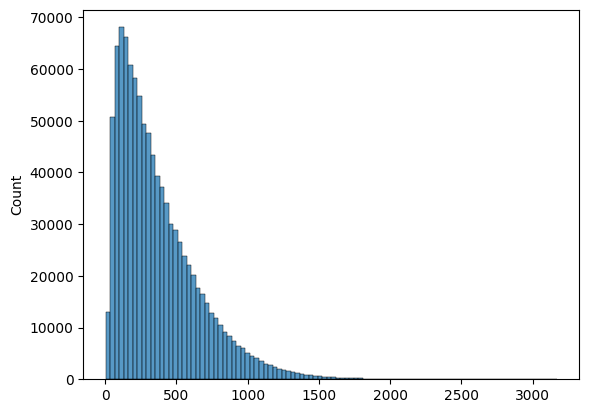

In [139]:
sns.histplot(adata.X[:1000000].sum(axis=1),bins=100)

In [27]:
from matplotlib.pyplot import rc_context

/tmp/ipykernel_13494/2163860404.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['x'] = round(tmp_df['x']*40).astype(int)
/tmp/ipykernel_13494/2163860404.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['y'] = round(tmp_df['y']*40).astype(int)
/tmp/ipykernel_13494/2163860404.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

ori cell number:  18569
cell number: 18569


/home/penglab/anaconda3/envs/python310/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


HVG number: 1122


/home/penglab/anaconda3/envs/python310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


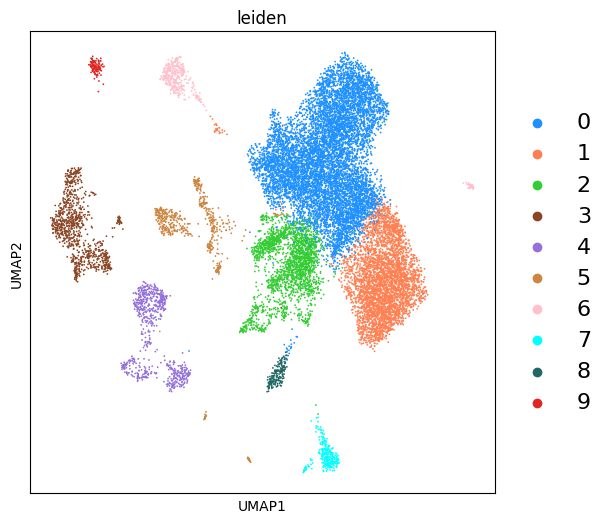

In [41]:
region_name = 'PIR'
region_id = id_to_brain[region_name]
sc.settings.vebosity=3
out_path = 'lyf/output_full_r671/parc_region'+str(region_id)+'.nrrd'
parc_mask_tmp = load_image(out_path)
acronym_name = brain_to_id[region_id]
if acronym_name not in id_parc_match:
    acronym_name = acronym+"-unassigned"
r_name = id_parc_match[acronym_name]


tmp_df = T1[T1['parcellation_index']==r_name]
tmp_df['x'] = round(tmp_df['x']*40).astype(int)
tmp_df['y'] = round(tmp_df['y']*40).astype(int)
tmp_df['z'] = round(tmp_df['z']*40)
tmp_df['z'] = tmp_df['z'].apply(lambda x: 456-x if x<228 else x)
tmp_df['z'] = tmp_df['z'].astype(int)
# label_tmp = parc_mask_tmp[tmp_df['z'],tmp_df['y'],tmp_df['x']]
# print(np.unique(label_tmp))

# s_names = np.array(tmp_df['cell_label'])
s_names = set(tmp_df['cell_label'])
print('ori cell number: ',len(s_names))
idx = [i for i,name in enumerate(adata.obs_names) if name in s_names]
# idx= np.isin(adata.obs_names,s_names,assume_unique=True)

adata_r = adata[idx,:].copy()

sc.pp.filter_cells(adata_r,min_genes=10)
sc.pp.filter_genes(adata_r,min_cells=3)
adata_r = adata_r[adata_r.obs.n_genes<2500,:]
print('cell number:',len(adata_r.X))
sc.pp.normalize_total(adata_r,target_sum=1e+3)
sc.pp.log1p(adata_r)
sc.pp.highly_variable_genes(adata_r,min_mean=0.0125,max_mean=3,min_disp=0.5)
adata_r.raw = adata_r
print('HVG number:',len(adata_r.var.highly_variable))
adata_r = adata_r[:,adata_r.var.highly_variable]
sc.pp.scale(adata_r,max_value=10)
sc.tl.pca(adata_r,svd_solver='arpack')

# tmp_df2 = tmp_df[tmp_df['cell_label'].isin(adata_r.obs_names)]
# parc_labels = parc_mask_tmp[tmp_df2['z'],tmp_df2['y'],tmp_df2['x']]
# print(np.unique(parc_labels))
# adata_r.obs['parc_label'] = np.array(parc_labels).astype(str)

region_name = str(brain_to_id[region_id])
if '/' in region_name:
    region_name = region_name.split('/')[0]+region_name.split('/')[1]
    
# fig,ax = plt.subplots(figsize=(10,6))
sc.pp.neighbors(adata_r,n_neighbors=10,n_pcs=40)
sc.tl.umap(adata_r)
sc.tl.leiden(adata_r,resolution=0.2)
sc.settings.figdir='all_figs/Fig5'
out_file = region_name+"_geneLeiden.png"
umap_palette = {'0':'#1E90FF','1':'#FF7F50','2':'#32CD32','3':'#8B4523','4':'#9370DB','5':'#CD853F','6':'#FFC0CB',
                '7':'#00FFFF','8':'#206864','9':'#E02623'}
with rc_context({'figure.figsize':(6,6)}):
    sc.pl.umap(adata_r,color=['leiden'],use_raw=False,save=out_file,palette=umap_palette,legend_fontsize=16)
# sc.pl.umap(adata_r,color=['leiden'],use_raw=False,palette=umap_palette)
# plt.savefig('all_figs/Fig5/'+region_name+'_geneLeiden.png',dpi=300)
# plt.close(fig)

# ### calculate score
# X_umap = adata_r.obsm['X_umap']
# plt.figure(figsize=(40,8))
# total_figs = int((np.max(parc_labels)+1)*np.max(parc_labels)/2)
# n = 1
# for i in range(1,np.max(parc_labels)):
#     for j in range(i+1,np.max(parc_labels)+1):
#         plot_data1 = pd.DataFrame({'x':X_umap[parc_labels==i,0],'y':X_umap[parc_labels==i,1]})
#         plot_data2 = pd.DataFrame({'x':X_umap[parc_labels==j,0],'y':X_umap[parc_labels==j,1]})
#         plt.subplot(2,total_figs,n)
#         sns.kdeplot(plot_data1['x'],fill=False,color='r',label='parc'+str(i))
#         sns.kdeplot(plot_data2['x'],fill=False,color='b',label='parc'+str(j))
#         plt.subplot(2,total_figs,total_figs+n)
#         sns.kdeplot(plot_data1['y'],fill=False,color='r',label='parc'+str(i))
#         sns.kdeplot(plot_data2['y'],fill=False,color='b',label='parc'+str(j))
#         n = n+1
# plt.xlabel('')
# plt.savefig('all_figs/Fig5/'+region_name+'_umapDist.png',dpi=300)
# plt.close()

In [36]:
np.unique(adata_r.obs['leiden'])

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

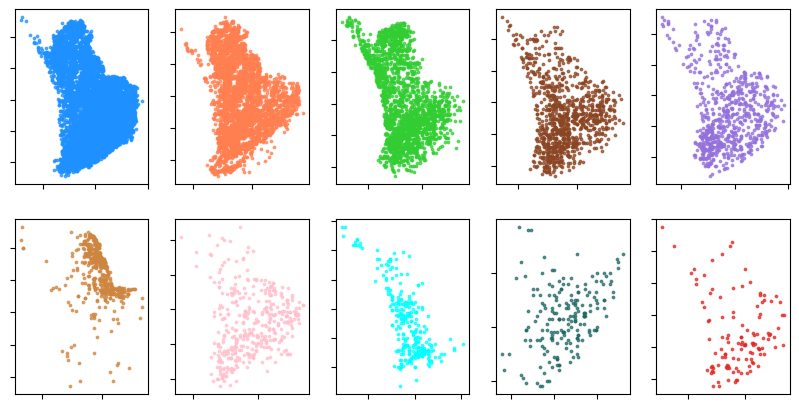

In [42]:
### 3D space
fig = plt.figure(figsize=(10,5))

label_leiden = np.array(adata_r.obs['leiden'])
tmp_df2 = tmp_df[tmp_df['cell_label'].isin(adata_r.obs_names)]

n = 1
for i in np.unique(label_leiden):
    c_df = tmp_df2[label_leiden == i]
    # plt.subplot(2,4,n)
    # pos = '25'+str(n)
    # ax = fig.add_subplot(2,5,n,projection = "3d")
    ax = fig.add_subplot(2,5,n)
    # ax.scatter(c_df['y'],c_df['x'],c_df['z'],s=1,
    #         marker='o',alpha=0.7,c=umap_palette[i])
    ax.scatter(c_df['y'],-c_df['z'],s=3,
            marker='o',alpha=0.7,c=umap_palette[i])
    # label_size = 12
    # ax.set_xlabel('LR axis',fontsize = label_size,labelpad = 0)
    # ax.set_ylabel('AP axis',fontsize = label_size)
    # ax.set_zlabel('DV axis',fontsize = label_size)
    # ax.set(xticklabels=[],yticklabels=[],zticklabels=[])
    ax.set(xticklabels=[],yticklabels=[])
    
    # ax.set_box_aspect(None,zoom=0.85)
    # ax.grid(False)
    # ax.view_init(elev=25,azim=30)
    n += 1

out_path = 'all_figs/Fig5/' + region_name +'_leiden_ccf.png'
plt.savefig(out_path,dpi=300,bbox_inches = 'tight')

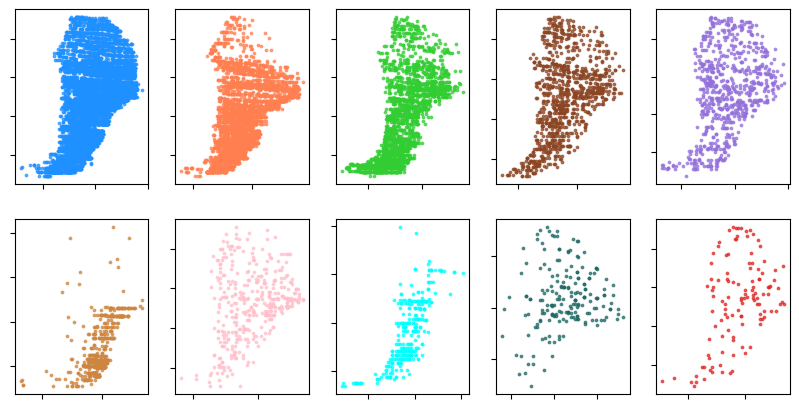

In [43]:
### 3D space
fig = plt.figure(figsize=(10,5))

label_leiden = np.array(adata_r.obs['leiden'])
tmp_df2 = tmp_df[tmp_df['cell_label'].isin(adata_r.obs_names)]

n = 1
for i in np.unique(label_leiden):
    c_df = tmp_df2[label_leiden == i]
    # plt.subplot(2,4,n)
    # pos = '25'+str(n)
    # ax = fig.add_subplot(2,5,n,projection = "3d")
    ax = fig.add_subplot(2,5,n)
    # ax.scatter(c_df['y'],c_df['x'],c_df['z'],s=1,
    #         marker='o',alpha=0.7,c=umap_palette[i])
    ax.scatter(c_df['y'],c_df['x'],s=3,
            marker='o',alpha=0.7,c=umap_palette[i])
    # label_size = 12
    # ax.set_xlabel('LR axis',fontsize = label_size,labelpad = 0)
    # ax.set_ylabel('AP axis',fontsize = label_size)
    # ax.set_zlabel('DV axis',fontsize = label_size)
    # ax.set(xticklabels=[],yticklabels=[],zticklabels=[])
    ax.set(xticklabels=[],yticklabels=[])
    
    # ax.set_box_aspect(None,zoom=0.85)
    # ax.grid(False)
    # ax.view_init(elev=25,azim=30)
    n += 1

out_path = 'all_figs/Fig5/' + region_name +'_leiden_ccf2.png'
plt.savefig(out_path,dpi=300,bbox_inches = 'tight')